In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [9]:
# Funkce pro odstranění sloupců, které mají určité procento NaN

def dropColumnsWithTooManyNaNs(table, percentage=0.25):
    # Odstranění sloupců, které mají počet NaN hodnot větší, než 25 % celkového počtu řádků

    dropList = [] # list sloupců, které mají více jak 20000 NaN hodnot

    for column in table.columns:
        if table[column].isnull().sum() > (table.shape[0]*percentage):
            dropList.append(column)

    filteredTable = table.drop(columns=dropList)  

    return dropList

# Načtení datasetu

In [5]:
# Cesta k tabulce s pacienty
filepath = './dataSepsis.csv'

# Načtení celé tabulky
fullSepsis = pd.read_csv(filepath, sep=';')

# Histogram pro zobrazení zastoupení NaN v jednotlivých features

<Axes: >

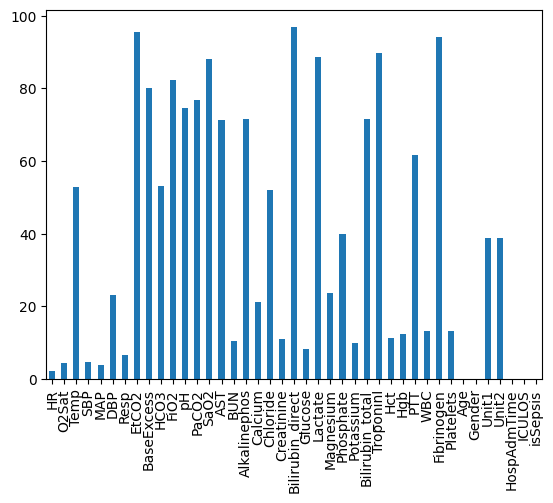

In [6]:
# Procentuální zastoupení NaN v datasetu (vztaženo na počet řádků)
NaN_percentage = (fullSepsis.isnull().sum()/fullSepsis.shape[0])*100
NaN_percentage.plot(kind="bar")


# Odstranění sloupců s příliš mnoha NaN

In [10]:
relevantFullSepsis = dropColumnsWithTooManyNaNs(fullSepsis)
relevantFullSepsis

['Temp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'Alkalinephos',
 'Chloride',
 'Bilirubin_direct',
 'Lactate',
 'Phosphate',
 'Bilirubin_total',
 'TroponinI',
 'PTT',
 'Fibrinogen',
 'Unit1',
 'Unit2']

# Heatmapa pro zobrazení korelace jednotlivých features mezi sebou 

In [ ]:
import seaborn as sb
corr = relevantFullSepsis.corr(method="pearson")

fig, ax = plt.subplots(figsize=(30, 20))
sb.heatmap(corr, cmap="hot_r", annot=True, linewidths=0.3)

# Odstranění přebytečných sloupců na základě korelace

In [5]:
relevantFullSepsis = relevantFullSepsis.drop(columns=["Hct", "SBP", "DBP"])

In [6]:
imputer = KNNImputer(n_neighbors=1000,weights="distance")
imputedFullSepsis = imputer.fit_transform(relevantFullSepsis)

In [7]:
imputedDF = pd.DataFrame(data = imputedFullSepsis,
                         columns=relevantFullSepsis.columns)
imputedDF

,HR,O2Sat,MAP,Resp,BUN,Calcium,Creatinine,Glucose,Magnesium,Potassium,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,isSepsis
0,103.0,90.0,82.861556,30.000000,14.0,9.300000,0.70,193.0,2.000000,3.8,12.5,5.7,317.0,83.14,0.0,-0.03,17.0,0.0
1,58.0,95.0,77.000000,11.000000,100.0,7.900000,2.50,78.0,2.500000,5.1,9.7,11.0,158.0,75.91,0.0,-98.60,10.0,0.0
2,91.0,94.0,74.000000,34.000000,30.0,10.900000,0.90,113.0,2.400000,3.8,8.8,8.3,465.0,45.82,0.0,-1195.71,11.0,0.0
3,92.0,100.0,86.306306,18.435861,9.0,8.362114,0.70,73.0,1.947985,3.8,12.2,12.0,298.0,52.01,1.0,-0.03,13.0,0.0
4,155.5,94.5,102.000000,33.000000,68.0,5.900000,3.80,263.0,1.900000,4.6,15.8,9.3,26.0,64.24,1.0,-0.05,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36297,59.0,95.0,110.000000,14.000000,9.0,8.800000,0.81,116.0,2.000000,3.5,13.1,7.0,154.0,76.00,1.0,-14.90,19.0,0.0
36298,81.0,99.0,71.000000,20.000000,8.0,8.800000,0.58,135.0,2.300000,4.0,13.8,12.6,238.0,84.00,0.0,-6.69,25.0,0.0
36299,76.0,96.0,79.000000,14.000000,6.0,9.800000,0.85,101.5,1.982550,3.1,16.1,10.8,201.0,30.00,1.0,-0.02,2.0,0.0
36300,76.0,89.0,102.000000,17.365838,49.0,7.800000,6.60,91.0,1.900000,4.2,8.9,12.5,188.0,60.00,0.0,-53.64,15.0,0.0


In [8]:
isSepsis = imputedDF["isSepsis"]
imputedDF = imputedDF.drop(columns=["isSepsis"])

In [9]:
outlier_scores = pd.DataFrame(index=imputedDF.index, columns=imputedDF.columns)

# Standardize the data
#scaler = StandardScaler()
#data_standardized = scaler.fit_transform(imputedDF)

# Create a LocalOutlierFactor model
lof_model = LocalOutlierFactor(n_neighbors=1000, contamination=0.05)

for feature in imputedDF.columns:
    # Fit the model and obtain outlier scores for the current feature
    outlier_scores[feature] = lof_model.fit_predict(imputedDF[[feature]])

# Fit the model and obtain outlier scores
#outlier_scores = lof_model.fit_predict(imputedDF[["HR"]])

# Replace outliers with NaNs
imputedDF[outlier_scores == -1] = np.nan

# Transform the remaining data back to the original scale
#data_transformed = scaler.inverse_transform(data_standardized)


In [12]:
imputer = KNNImputer(n_neighbors=1000,weights="distance")
filteredSepsis = imputer.fit_transform(imputedDF)

filteredSepsis = pd.DataFrame(data = imputedFullSepsis,
                         columns=relevantFullSepsis.columns)
filteredSepsis

,HR,O2Sat,MAP,Resp,BUN,Calcium,Creatinine,Glucose,Magnesium,Potassium,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,isSepsis
0,103.0,90.0,82.861556,30.000000,14.0,9.300000,0.70,193.0,2.000000,3.8,12.5,5.7,317.0,83.14,0.0,-0.03,17.0,0.0
1,58.0,95.0,77.000000,11.000000,100.0,7.900000,2.50,78.0,2.500000,5.1,9.7,11.0,158.0,75.91,0.0,-98.60,10.0,0.0
2,91.0,94.0,74.000000,34.000000,30.0,10.900000,0.90,113.0,2.400000,3.8,8.8,8.3,465.0,45.82,0.0,-1195.71,11.0,0.0
3,92.0,100.0,86.306306,18.435861,9.0,8.362114,0.70,73.0,1.947985,3.8,12.2,12.0,298.0,52.01,1.0,-0.03,13.0,0.0
4,155.5,94.5,102.000000,33.000000,68.0,5.900000,3.80,263.0,1.900000,4.6,15.8,9.3,26.0,64.24,1.0,-0.05,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36297,59.0,95.0,110.000000,14.000000,9.0,8.800000,0.81,116.0,2.000000,3.5,13.1,7.0,154.0,76.00,1.0,-14.90,19.0,0.0
36298,81.0,99.0,71.000000,20.000000,8.0,8.800000,0.58,135.0,2.300000,4.0,13.8,12.6,238.0,84.00,0.0,-6.69,25.0,0.0
36299,76.0,96.0,79.000000,14.000000,6.0,9.800000,0.85,101.5,1.982550,3.1,16.1,10.8,201.0,30.00,1.0,-0.02,2.0,0.0
36300,76.0,89.0,102.000000,17.365838,49.0,7.800000,6.60,91.0,1.900000,4.2,8.9,12.5,188.0,60.00,0.0,-53.64,15.0,0.0


In [13]:
filteredSepsis.isnull().sum()

HR             0
O2Sat          0
MAP            0
Resp           0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
HospAdmTime    0
ICULOS         0
isSepsis       0
dtype: int64

In [ ]:
import matplotlib.pyplot as plt

for column in filteredSepsis.columns:
    plt.figure()  # Create a new figure for each histogram
    filteredSepsis[column].plot(kind='hist', bins=20, title=f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [166]:
# Rozdělení tabulky do dvou datasetů
sepsis0 = relevantFullSepsis[relevantFullSepsis["isSepsis"] == 0] # dataset pacientů bez sepse (0)
sepsis1 = relevantFullSepsis[relevantFullSepsis["isSepsis"] == 1] # dataset pacientů se sepsí (1)

# Předzpracování datasetu s pacienty bez sepse

In [167]:
relevantSepsis0 = replaceOutliers(sepsis0)
# odstranění řádků, které mají 1 a více NaN


In [168]:
relevantSepsis0 = relevantSepsis0.dropna()
relevantSepsis0

,HR,O2Sat,MAP,Resp,BUN,Calcium,Creatinine,Glucose,Magnesium,Potassium,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,isSepsis
5,73.0,99.0,67.00,16.5,28.0,7.40,1.20,129.0,1.8,4.50,11.4,11.4,357.0,87.08,1.0,-2.23,2.0,0.0
10,95.0,100.0,62.33,18.0,19.0,7.30,0.80,65.0,1.4,4.10,10.5,12.7,315.0,59.73,1.0,-0.03,17.0,0.0
16,98.0,94.0,62.00,15.0,11.0,7.40,0.50,122.0,2.0,4.10,9.9,15.2,205.0,87.80,0.0,-122.18,10.0,0.0
19,84.0,98.0,67.33,29.0,37.0,6.60,1.50,75.0,1.7,3.90,8.7,10.9,160.0,70.81,0.0,-223.30,8.0,0.0
21,89.0,96.0,55.00,14.0,19.0,8.30,0.90,140.0,1.7,4.30,10.1,17.0,234.0,63.77,1.0,-4.80,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36292,82.0,97.0,72.00,22.0,19.0,8.90,1.33,151.0,2.0,3.50,13.3,14.6,263.0,100.00,0.0,-2.83,14.0,0.0
36293,74.0,97.0,72.00,12.0,14.0,7.50,0.79,90.0,1.6,4.10,8.4,6.4,96.0,81.00,0.0,-66.13,16.0,0.0
36296,73.0,100.0,78.00,14.5,11.0,4.79,1.13,141.5,2.2,4.65,10.3,7.2,71.0,71.00,1.0,-29.57,10.0,0.0
36297,59.0,95.0,110.00,14.0,9.0,8.80,0.81,116.0,2.0,3.50,13.1,7.0,154.0,76.00,1.0,-14.90,19.0,0.0


# Předzpracování datasetu s pacienty se sepsí 

In [108]:
relevantSepsis1 = replaceOutliers(sepsis1)
filtered_sepsis1 = relevantSepsis1.dropna(thresh=relevantSepsis1.shape[1]-6)
filledSepsis1 = filtered_sepsis1.ffill(axis=0)
filledSepsis1.dropna(inplace=True)
filledSepsis1

,HR,O2Sat,MAP,Resp,BUN,Calcium,Creatinine,Glucose,Magnesium,Potassium,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,isSepsis
8,89.0,100.0,85.00,17.0,9.0,8.4,0.70,137.0,2.5,3.5,11.2,10.6,184.0,65.79,1.0,-0.02,35.0,1.0
47,93.0,94.0,90.00,16.0,9.0,7.5,0.70,141.0,1.8,4.3,7.4,15.4,167.0,68.20,1.0,-0.02,7.0,1.0
55,86.0,100.0,74.00,21.0,27.0,7.7,1.10,181.0,2.5,4.6,8.6,10.8,136.0,68.98,0.0,-0.01,29.0,1.0
67,135.0,100.0,53.33,14.0,19.0,7.5,0.70,181.0,2.2,3.7,8.8,23.3,246.0,56.97,1.0,-0.01,101.0,1.0
156,95.0,98.0,102.00,15.0,19.0,8.1,0.60,134.0,2.3,3.8,8.7,10.6,284.0,43.43,1.0,-0.02,96.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36027,87.0,95.5,104.50,20.0,12.0,10.3,1.30,159.0,2.2,4.4,9.6,10.7,252.0,45.00,1.0,-0.05,44.0,1.0
36045,125.5,99.5,56.00,15.0,12.0,8.0,1.30,181.0,2.2,4.7,10.4,21.7,126.0,81.00,1.0,-0.05,13.0,1.0
36086,74.0,96.0,79.00,15.0,23.0,8.3,0.66,132.0,1.9,3.1,9.4,16.0,435.0,50.00,0.0,-0.05,13.0,1.0
36114,86.0,95.0,103.00,28.0,23.0,7.9,0.70,134.0,2.1,3.6,9.5,15.8,239.0,72.00,0.0,-0.01,9.0,1.0


In [197]:
sampleSepsis1 = filledSepsis1.sample(n=1000)
sampleSepsis0 = relevantSepsis0.sample(n=1000)

In [129]:
sampleSepsis0.reset_index(inplace=True)
sampleSepsis1.reset_index(inplace=True)


In [198]:
from scipy.stats import shapiro, mannwhitneyu,ttest_ind

# Hodnocení redundance:
indices=[]
indices_out = []
for i in range(sampleSepsis0.shape[-1]):


    _, p_sepsis1 = shapiro(sampleSepsis1.iloc[:, i])
    _, p_sepsis0 = shapiro(sampleSepsis0.iloc[:, i])

    if (p_sepsis1<0.05 or p_sepsis0<0.05):
        _,p = mannwhitneyu(sampleSepsis0.iloc[:, i],sampleSepsis1.iloc[:, i])
    else:
        _,p = ttest_ind(sampleSepsis0.iloc[:, i], sampleSepsis1.iloc[:, i])

    
    if (p<0.05):
        indices.append(sampleSepsis0.iloc[:, i].name)
    else:
        indices_out.append(sampleSepsis0.iloc[:, i].name)

indices_out

['O2Sat', 'Age']

In [ ]:
import matplotlib.pyplot as plt

# Create individual scatter plots for each column
for column in filledSepsis1.columns:
    plt.figure()  # Create a new figure for each scatter plot
    plt.scatter(range(len(filledSepsis1[column])), filledSepsis1[column])
    plt.title(f'Scatter Plot for Column {column}')
    plt.xlabel('Index')
    plt.ylabel('Values')

plt.show()

